# Examples - Decision trees
--- 

### La Serena School for Data Science

August 2017 <br>
Instructors:  P. Protopapas

Repurposed by Ashish Mahabal for AY 119 (Caltech, 2018)
Repurposed by Ashish Mahabal for ZTF SS (2018)


***

* Decision Trees
* Random Forests
* Ensemble Methods

For more reading, check out An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (available through [Springer](http://www-bcf.usc.edu/~gareth/ISL/), as well as the scikit-learn [documentation](http://scikit-learn.org/stable/modules/tree.html).

***

In [3]:
# IMPORT STUFF
%matplotlib inline 

import io

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
from IPython.display import Image
import pydotplus



from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn import tree


/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# COLOR STUFF 
from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [5]:
# A generic function to do CV

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

In [6]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return(clf, Xtrain, ytrain, Xtest, ytest)


In [7]:

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clf.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [8]:
# This function creates images of tree models using pydotplus
# https://github.com/JWarmenhoven/ISLR-python
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = io.StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, proportion=True, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [9]:
# Print decision tree model 'dt'
def display_dt(dt):
    dummy_io = io.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io, proportion=True) 
    print(dummy_io.getvalue())

# The  wine aficionado 

<img src="http://www.winemaniacs.com/wp-content/uploads/2013/04/WineRotator-2000x925.jpg">

Can a wine maker predict how a wine will be received based on the chemical properties of the wine? Are there chemical indicators that correlate more strongly with the perceived "quality" of a wine?

We examine the wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. This data records 11 chemical properties (such as the concentrations of sugar, citric acid, alcohol, pH etc.) of thousands of red and white wines from northern Portugal, as well as the quality of the wines, recorded on a scale from 1 to 10. In this problem, we will only look at the data for *red* wine.

## Import data

Import only the data for **red** wine from the <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'>dataset repository</a>.

In [10]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


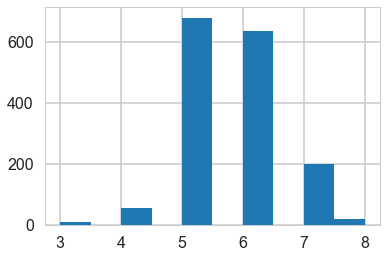

In [11]:
print(df.shape)
plt.hist(df.quality);
#plt.plot(df.sulphates, df.quality, '*')

----

We will use the *quality* column as our target variable. Except that we will simplify the problem to a binary world in which wines are either "bad" ($\text{score} < 7$) or "good" ($\text{score} \geq 7)$. For example, if originally $Y = [1,3,8,4,7]$, the new $Y$ should be $[0,0,1,0,1]$.

In [12]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

Let's get the column names corresponding to the predictors

In [13]:
Xnames = list(df.columns.values[1:11])


---


### Recall: Evaluation Metrics
First, notice that we're actually dealing with a relatively small number of good wines in out dataset.

In [14]:
np.mean(df['target'])

0.1357098186366479

---

Usually, the goal is to identify the members of the positive class (the rare class) successfully -- this could be either the good wines or the patients presenting a rare disease. It is common practice to define the following ratios:

The **recall** rate (also called the sensitivity or the true positive rate) is the ratio of true positive guesses among all positives:
$$\text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$
The **precision** is the ratio of the true positive guesses over all the positive guesses:
$$\text{precision} = \frac{TP}{TP+FP}.$$
Because precision and recall both provide valuable information about the quality of a classifier, we often want to combine them into a single general-purpose score. The **F1** score is defined as the harmonic mean of recall and precision:
$$F_1 = \frac{2\times\text{recall}\times\text{precision}}{\text{recall} + \text{precision}}.$$

The harmonic mean of two numbers is closer to the smaller of the two numbers than the standard arithmetic mean. The F1 score thus tends to favor classifiers that are strong in both precision and recall, rather than classifiers that emphasize one at the cost of the other.

***We'll use the `score_func` option set to ``f1`` in our `do_classify` function for these classifications.** There are a lot of evaluation metrics we can use, see the [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html).



# 1. Decision Trees (Classification)



## Fitting Decision Trees

Building a decision tree isn't really much harder than reading one, here's the essential rundown:

Let's say we're building a classification tree by considering a list of predictors. In our example above we want to be able to classify good wines from the rest using things like fixed acidity, pH, alcohol, etc. These are all continuous variables, generically let's call them $X_{i1}, X_{i2}, ..., X_{ip}$ ($i$ for wine, $p$ for predictors). We also have an observed label $Y_i$ for each wine. 

We first assign everyone to the same class, say $\hat{Y}_i = 1$. We can calculate the squared error $Err = \sum_i {(\hat{Y}_i - Y_i)^2}$

- At **each step** of the algorithm we consider a list of possible decision (or split), for example $X_{10} > 12$, i.e. alcohol content is greater than 12%.
- For each possible decision we recalculate the predictor for that rule, for example $\hat{Y}_i = 1$ if $X_{10} > 12$ and $0$ otherwise.
- We recalculate the error for each possible decision: $Err = \sum_i {(\hat{Y}_i - Y_i)^2}$
- We choose the decision that reduces the error by the largest amount
- then keep going...

<img src="Decision_tree.png">




Here we'll consider classification but Decision trees can be use for regression as we know.

In [15]:
# Create test/train mask
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [16]:
#
#
# make sure we didn't get unlucky in our mask selection
print("% Good wines in Training:", np.mean(df.target[mask]), np.std((df.target[mask])))
print("% Good wines in Testing:", np.mean(df.target[~mask]), np.std((df.target[~mask])))

% Good wines in Training: 0.12930135557872785 0.33553318021357187
% Good wines in Testing: 0.1453125 0.35241563152583




### Fit a Decision Tree

Let's first fit on two covariates to help us visualize what's going on. Have a look at the options on the [help page](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). We'll be optimizing over two options here: `max_depth` - the maximum depth of the tree, `min_samples_leaf` - the minimum number of samples required to be at a leaf node.

In [17]:

# I NEED THIS SOMEHOW
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

# 
clfTree1 = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

subdf=df[['sulphates', 'fixed acidity']]
X=subdf.values
y=(df['target'].values==1)*1

# TRAINING AND TESTING
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# FIT THE TREE 
clf=clfTree1.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(confusion_matrix(ytest, clf.predict(Xtest)))
print("########################################################")

############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.85
[[547   0]
 [ 93   0]]
########################################################


In [18]:
display_dt(clf)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 0.685\ngini = 0.225\nsamples = 100.0%\nvalue = [0.871, 0.129]"] ;
1 [label="X[1] <= 9.75\ngini = 0.102\nsamples = 67.8%\nvalue = [0.946, 0.054]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 5.65\ngini = 0.07\nsamples = 57.1%\nvalue = [0.964, 0.036]"] ;
1 -> 2 ;
3 [label="gini = 0.266\nsamples = 2.0%\nvalue = [0.842, 0.158]"] ;
2 -> 3 ;
4 [label="gini = 0.062\nsamples = 55.2%\nvalue = [0.968, 0.032]"] ;
2 -> 4 ;
5 [label="X[0] <= 0.645\ngini = 0.251\nsamples = 10.6%\nvalue = [0.853, 0.147]"] ;
1 -> 5 ;
6 [label="gini = 0.167\nsamples = 7.9%\nvalue = [0.908, 0.092]"] ;
5 -> 6 ;
7 [label="gini = 0.426\nsamples = 2.7%\nvalue = [0.692, 0.308]"] ;
5 -> 7 ;
8 [label="X[0] <= 0.905\ngini = 0.41\nsamples = 32.2%\nvalue = [0.712, 0.288]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="X[1] <= 7.35\ngini = 0.445\nsamples = 25.9%\nvalue = [0.665, 0.335]"] ;
8 -> 9 ;
10 [label="gin

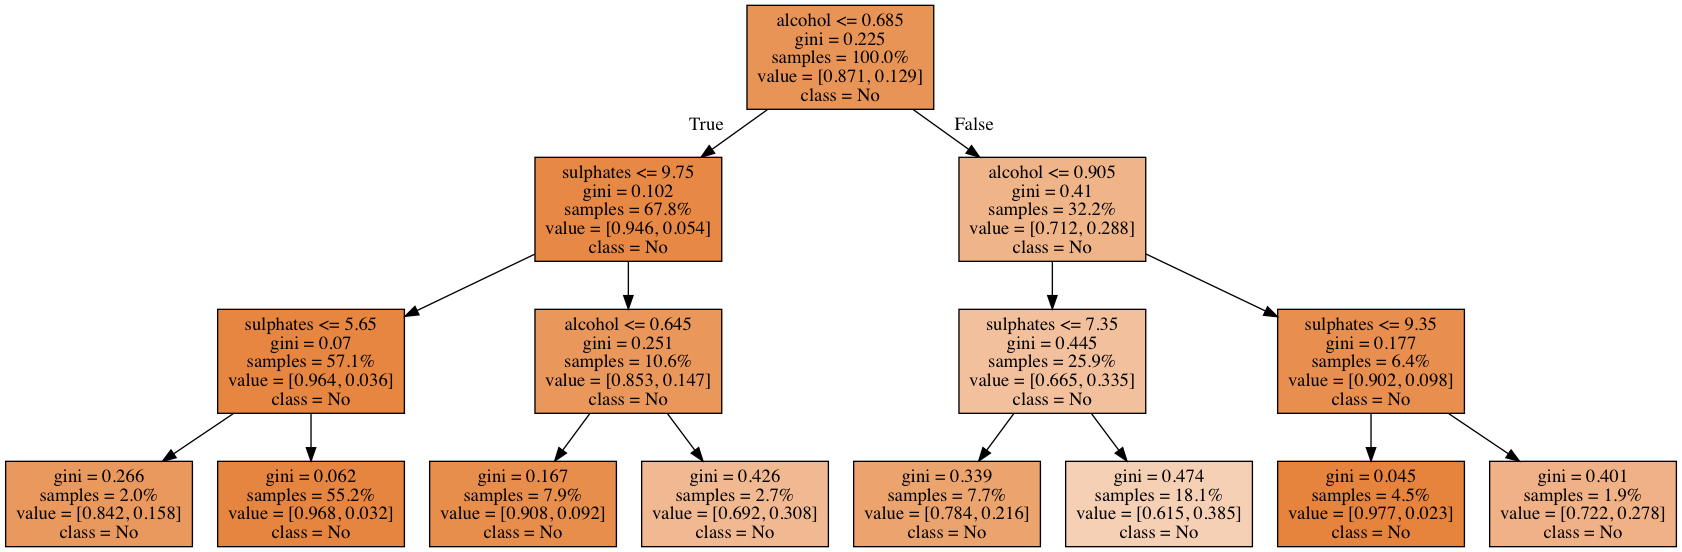

In [20]:
graph3 = print_tree(clf, features=['alcohol', 'sulphates'], class_names=['No', 'Yes'])
Image(graph3.create_png())

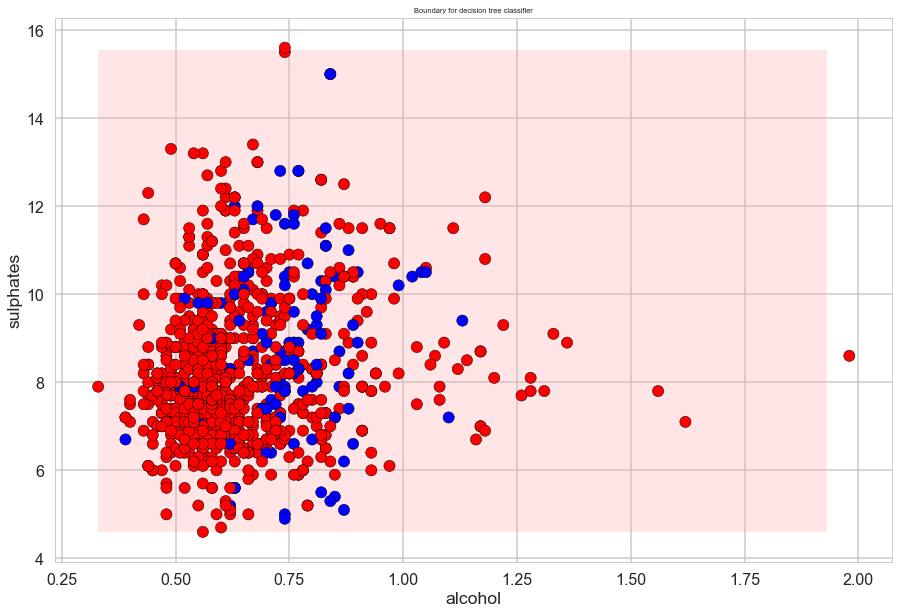

In [21]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'sulphates'], alpha = 1, plot_test = False)



# Lets use CV to determine the debth of the tree 

In [22]:
parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [ 1,2, 3, 4, 5, 6]}
clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=10, n_folds=5, score_func=None);

print(clf.max_depth, clf.min_samples_leaf)


3 6


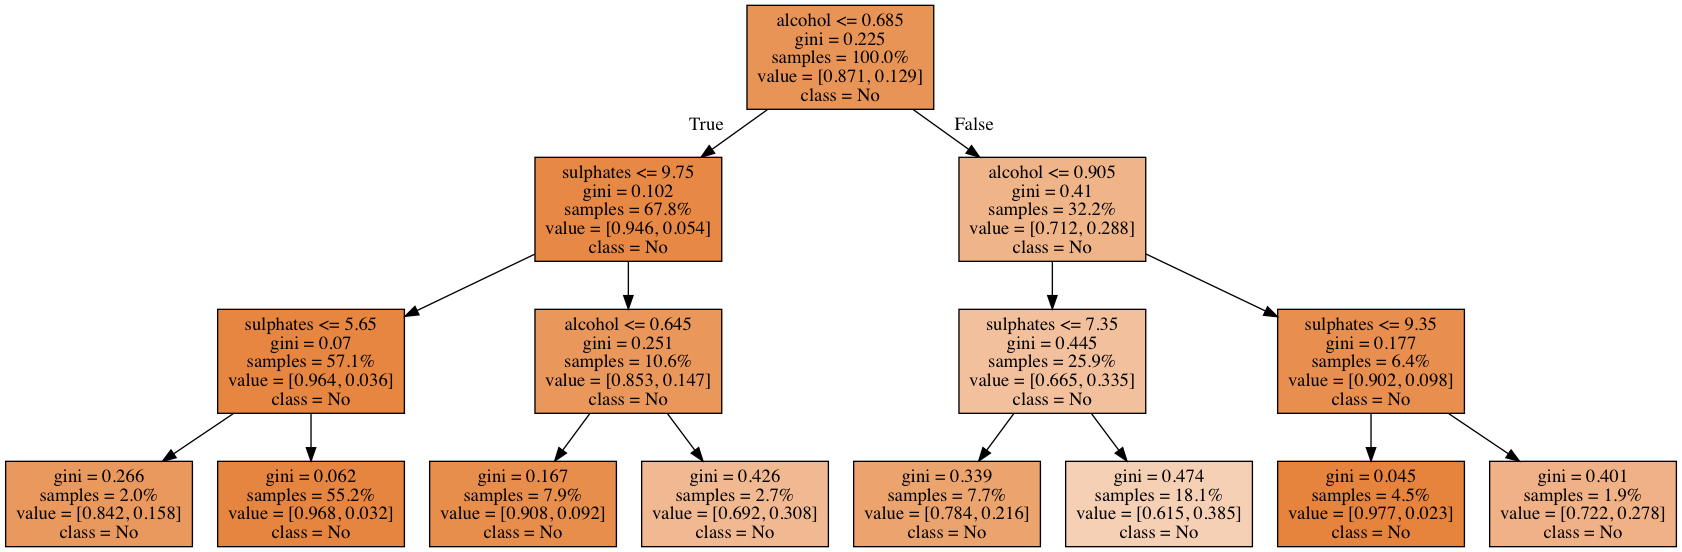

In [23]:
graph3 = print_tree(clf, features=['alcohol', 'sulphates'], class_names=['No', 'Yes'])
Image(graph3.create_png())

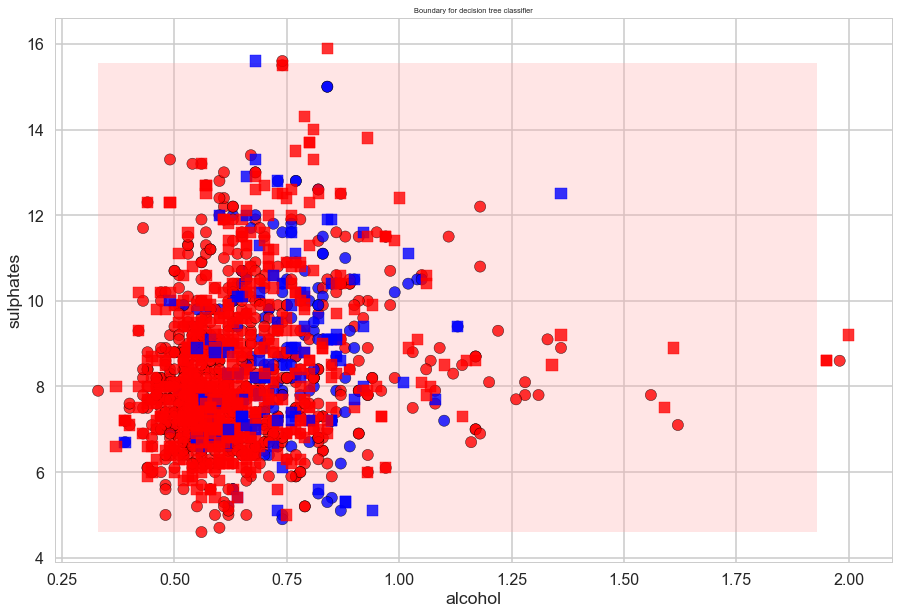

In [24]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clf, 
           lab = ['alcohol', 'sulphates'], alpha = .8, plot_test = True)

using mask
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.85
[[514  33]
 [ 63  30]]
########################################################


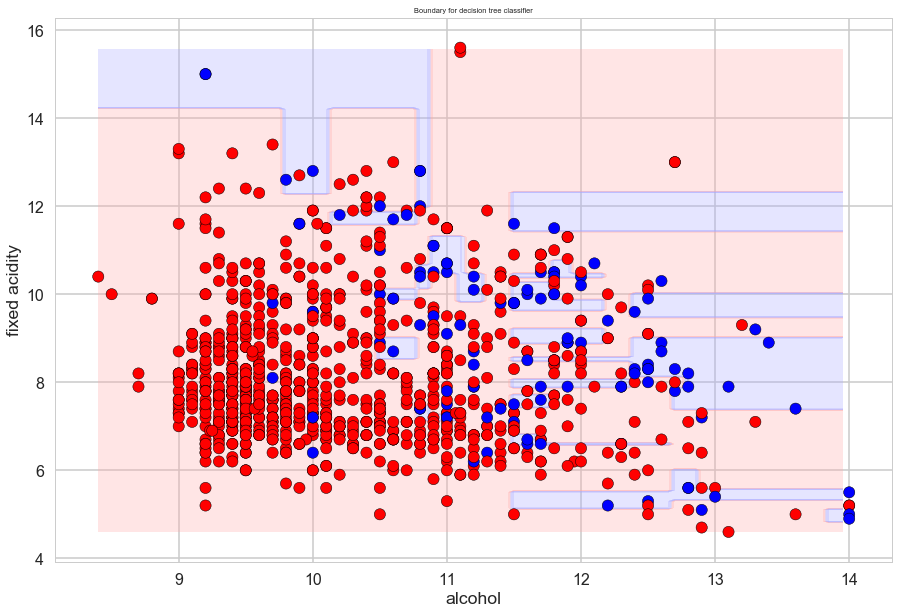

In [25]:
# using the function we built (same as before)

clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [18], 'min_samples_leaf': [2]}
clfTree_temp2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp2, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

## More Predictors

The prediction accuracy says we're doing quite well, but it seems like that's being driven by having such a large number of not excellent wines, even when optimizing the $F1$ score. Let's see if we can't increase the including all the covariates.

In [26]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 1, score_func = 'f1')
print(clf.max_depth, clf.min_samples_leaf)

using mask


/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cla

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cla

############# based on standard predict ################
Accuracy on training data: 0.93
Accuracy on test data:     0.87
[[520  27]
 [ 59  34]]
########################################################
3 6


# 2. Random Forests

Random forests works by aggregating the results from a number of randomly perturbed decision trees constructed to explain the data.

### A bit on bootstrap aggregation
The idea of random forests arises naturally by first considering Tree bagging. In tree bagging we do the following $b$ times:

1. Take a random subsample of your data
2. Build a classification (or regression) tree like in the previous section
3. repeat

For a new data point we can then simply run that point through all the $b$ trees constructed, get all the decisions $\hat{Y}_1,..., \hat{Y}_b$ and take a majority vote. This form of averaging gets rid of some of the over-fitting issues found in just using one tree. Plus fitting these trees costs a lot computationally, so what else can we do?

### Leads to Random Forests?
This method is very similar to the bootstrap aggregation method. However, as the name suggests some extra randomness is injected into the building of the trees. It turns out that the trees that are build from the random subsample of your data are quite similar, so the solution is quite simple. In Random Forests we do the following $b$ times:

1. Take a random subsample of your data
2. randomly select a subset of predictors to be used in building the tree
3. Build a classification (or regression) tree with only those variables selected in 2
4. repeat

We take a majority vote the same as before. Have a look at the help page for the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), we'll be optimizing two options: `n_estimators` - the number of trees in the forest, `max_features` - the number of features to consider when looking for the best split (step 2 above).


In [27]:
from sklearn.ensemble import RandomForestClassifier



clfForest = RandomForestClassifier(n_estimators=10, oob_score=True, max_features='auto')



subdf=df[Xnames]
X=subdf.values
y=(df['target'].values==1)*1

# TRAINING AND TESTING
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# FIT THE TREE 
clf=clfForest.fit(Xtrain, ytrain)

print(clfForest.n_estimators)

training_accuracy = clfForest.score(Xtrain, ytrain)
test_accuracy = clfForest.score(Xtest, ytest)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(confusion_matrix(ytest, clf.predict(Xtest)))
print("########################################################")

parameters = {"n_estimators": list(range(1, 20))}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')
print(clfForest.n_estimators)

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10
############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.89
[[533  14]
 [ 55  38]]
########################################################
using mask


/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encou

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encou

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encou

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.87
[[520  27]
 [ 54  39]]
########################################################
7


/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


## Relative Importance
We can get a measure of how important a variable is from a random forest, it's essentially a measure of how well each particular variable is able to predict well when it is selected, for more on this and other details check out [this webpage](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp).

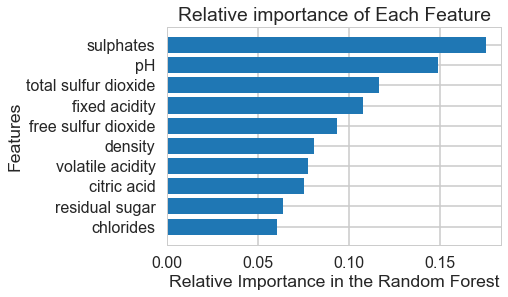

In [28]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

# 3. More Ensemble Methods

Ensemble methods generalize this idea of putting many weak classifiers together (in a clever way) to build very accurate predictors. We saw this before with Random Forests and Bagging in the previous section. In this section we'll concentrate on a few particular Ensemble Methods

## AdaBoost Classifier
AdaBoost is short for Adaptive Boosting, the idea is quite simple. First you have some base classifier, like a Decision tree for example. 

First you assign to each of your n data points a weight of $w_i = 1/n$, then you do:

1. fit that classifier (e.g. tree) on all your data, weighted by $w_i$
2. test to see how well your classifier predicts your data
3. data points that are miss-classified get a slightly higher weight, but update all the weights to $w_{i, new} = w_{i} \exp({\alpha_{t, x_i, y_i}})$

In step 1, the way this weighting is done is by considering a weighted loss. For the details of this check out the Wikipedia article on [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost#Example_algorithm_.28Discrete_AdaBoost.29). The only detail that is important to us now is that ${\alpha_{t, x_i, y_i}}$ is some number that is large when $y_i$ is correctly classified and small otherwise.

What this means is that every successive classifier (tree) puts more emphasis on classifying data points that the previous classifier missed. In this way each classifier can concentrate on a subset of the data. See the [help page](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) for more tuning parameters.

In [29]:
list(range(5))

[0, 1, 2, 3, 4]

In [30]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": list(range(10, 60))}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.86
[[511  36]
 [ 56  37]]
########################################################


## Gradient Boost Classifier

This classifier is also an ensemble method with trees as its base classifier, like AdaBoost it creates a sequence of classifiers that 'correct each other' sequentially. 

If you want to read more about this, and other Ensemble methods, check these places out:

- An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (see header)
- [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) by Trevor Hastie, Robert Tibshirani, Jerome Friedman
- [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning))
- [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning)


In [31]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": list(range(30, 60)), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.88
[[525  22]
 [ 53  40]]
########################################################


### Visualizing Classifiers Using Decision Surfaces
Using this function and the results from the "importance" analysis above, **subset** the data matrix to include just the **two features of highest importance**. Then **plot** the decision surfaces of a <a href='http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier'>decision tree classifier</a>,  and a random forest classifier with **number of trees set to 15**

In [32]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model


def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    

imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

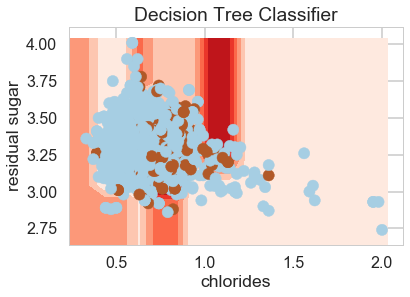

/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


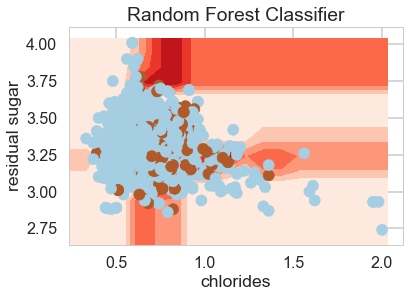

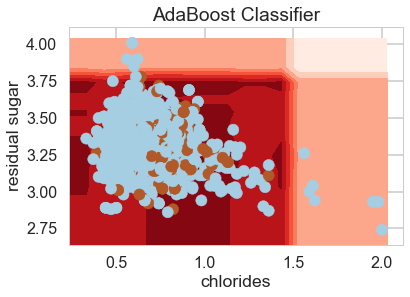

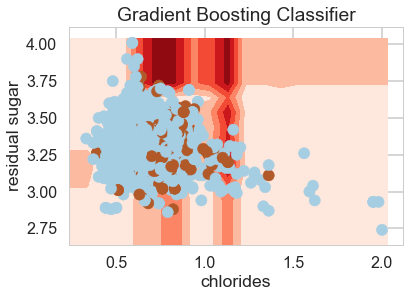

In [33]:
X_imp = df[df.columns[imp_cols]].values
Y = df.target.values

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB
               ]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in range(4):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)